In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

### Phase- I: Exploratory Data Analysis

In [3]:
data_train = pd.read_csv("Data_Train.csv")

In [4]:
data_train.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

In [5]:
data_train['Power'] = pd.to_numeric(data_train['Power'],errors = 'coerce')

In [6]:
data_train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,NaN,17.74


In [7]:
data_train.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,6019.000000,6.019000e+03,6017.000000,5983.000000,5876.000000,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,18.134961,1621.276450,113.253050,5.278735,9.479468
std,3.269742,9.126884e+04,4.582289,601.355233,53.874957,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,0.440000
25%,2011.000000,3.400000e+04,15.170000,1198.000000,75.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.150000,1493.000000,97.700000,5.000000,5.640000
75%,2016.000000,7.300000e+04,21.100000,1984.000000,138.100000,5.000000,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,160.000000


Mileage has a minimum of 0 which seems odd no serviceable car will ever have 0 Mileage, thus, we need to substitute it by a suitable measure. Since, both mean and median are fairly equivalent, we chose to go with the mean.

Same treatment would be attributed to Seats column where 0 will be substituted with the mode, 5.

In [8]:
data_train['Mileage'] = data_train['Mileage'].replace(0,data_train['Mileage'].mean())
data_train['Seats'] = data_train['Seats'].replace(0,5)

In [9]:
data_train.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                 143
Seats                  42
New_Price            5195
Price                   0
dtype: int64

#### Notes

Problem with Mileage is that it has 0s as well as NAs in many rows. 

If Engine information is missing power, seats, new price are also missing.

In some cases, for same models, sometimes the information is missing, sometimes it's not.

Can't substitute the data for one model to other, as other columns might be a mismatch to substitution.

Maximum NaNs in New_Price (5195 out of 6019), decision is to drop the column.

Normalize the Mileage as it is measured along different scales for CNG, LPG, Diesel, Petrol, Electric.

In [10]:
# Normalizing the numerical columns to bring them onto same scale
data_train['Mileage']=(data_train['Mileage']-data_train['Mileage'].min())/(data_train['Mileage'].max()-data_train['Mileage'].min())
data_train['Engine']=(data_train['Engine']-data_train['Engine'].min())/(data_train['Engine'].max()-data_train['Engine'].min())
data_train['Power']=(data_train['Power']-data_train['Power'].min())/(data_train['Power'].max()-data_train['Power'].min())
data_train['Kilometers_Driven']=(data_train['Kilometers_Driven']-data_train['Kilometers_Driven'].min())/(data_train['Kilometers_Driven'].max()-data_train['Engine'].min())

In [11]:
train_x  = data_train.drop(labels = 'New_Price',axis = 1)

Dropping all the rows with NaNs yield 5975 rows of observations

In [12]:
train_x = train_x.dropna(axis = 0)
train_x.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

In [13]:
print(data_train['Name'].nunique())
print(train_x['Name'].nunique())

1876
1811


Dropping all rows with NaNs is not a feasible solution as we lose information about some unique entries BUT it can help us ascertain the distribution of columns without NaNs misleading us.

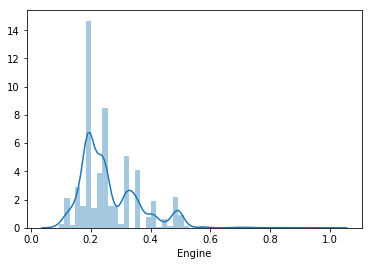

In [14]:
sns.distplot(train_x['Engine'])
plt.show()

In [15]:
print(train_x['Engine'].mean(), train_x['Engine'].median(), train_x['Engine'].mode())

0.26219128791884166 0.24021262234222074 0    0.189841
dtype: float64


Trying to fill the remaining NaNs or nulls in the column Engine with the mode as the above distribution shows it to not have a normal distribution.

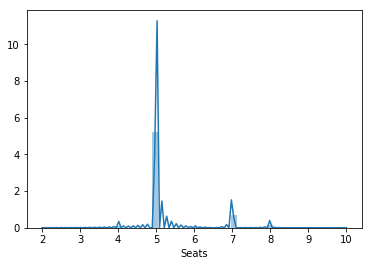

In [16]:
sns.distplot(train_x['Seats'])
plt.show()

It is viable to fill NaNs in Seats column with 5 as it happens to the mode and a majority of the used vehicles on sale are 5 seaters.

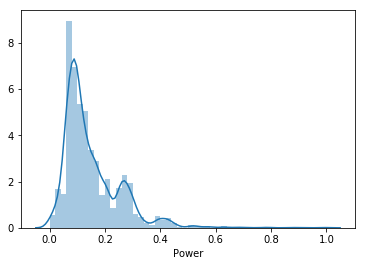

In [17]:
sns.distplot(train_x['Power'])
plt.show()

In [18]:
print(train_x['Power'].mean(), train_x['Power'].median(), train_x['Power'].mode())

0.15039348370667405 0.12076835298592623 0    0.075694
dtype: float64


Power column too is not normally distributed. Most of the vehicles have power roughly in the range of 0 to 200.

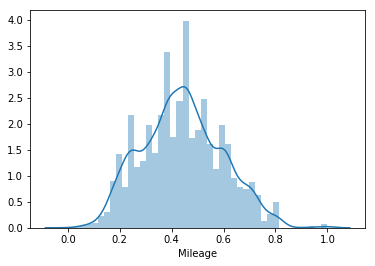

In [19]:
sns.distplot(train_x['Mileage'])
plt.show()

In [20]:
print(train_x['Mileage'].mean(), train_x['Mileage'].median(), train_x['Mileage'].mode())

0.4408369014688203 0.4347826086956521 0    0.460575
dtype: float64


Mileage is nearly normally distributed, it's mean, median and mode are near equivalent. We can chose to substitute NAs with the mean.

In [21]:
data_train['Power'].fillna(data_train['Power'].median(), inplace = True)
data_train['Engine'].fillna(data_train['Engine'].median(), inplace = True)
data_train['Mileage'].fillna(data_train['Mileage'].median(), inplace = True)
data_train['Seats'].fillna(data_train['Seats'].mode()[0], inplace = True)
data_train = data_train.drop('New_Price',axis = 1)

In [22]:
data_train.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
dtype: int64

### Phase- II: Encoding Categorical Data

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
label_codex = LabelEncoder()
data_train["Name_labels"] = label_codex.fit_transform(data_train["Name"])
data_train["Year_labels"] = label_codex.fit_transform(data_train["Year"])
data_train["Owner_Type_labels"] = label_codex.fit_transform(data_train["Owner_Type"])
data_train["Location_labels"] = label_codex.fit_transform(data_train["Location"])
data_train["Fuel_Type_labels"] = label_codex.fit_transform(data_train["Fuel_Type"])
data_train["Transmission_labels"] = label_codex.fit_transform(data_train["Transmission"])

In [25]:
# Rearranging the columns
data_train= data_train[['Name_labels', 'Location_labels', 'Year_labels', 'Kilometers_Driven', 'Fuel_Type_labels',
       'Transmission_labels', 'Owner_Type_labels', 'Mileage', 'Engine', 'Power', 'Seats','Price']]

In [26]:
data_train.head()

,Name_labels,Location_labels,Year_labels,Kilometers_Driven,Fuel_Type_labels,Transmission_labels,Owner_Type_labels,Mileage,Engine,Power,Seats,Price
0,1200,9,12,0.011051,0,1,0,0.744289,0.156261,0.045569,5.0,1.75
1,512,10,17,0.006281,1,1,0,0.488946,0.254809,0.174971,5.0,12.50
2,486,2,13,0.007051,4,1,0,0.434783,0.190179,0.103652,5.0,4.50
3,1059,2,14,0.013358,1,1,0,0.529477,0.198448,0.103766,7.0,6.00
4,23,3,15,0.006231,1,0,2,0.324245,0.319946,0.202739,5.0,17.74


#### Discerning Correlation

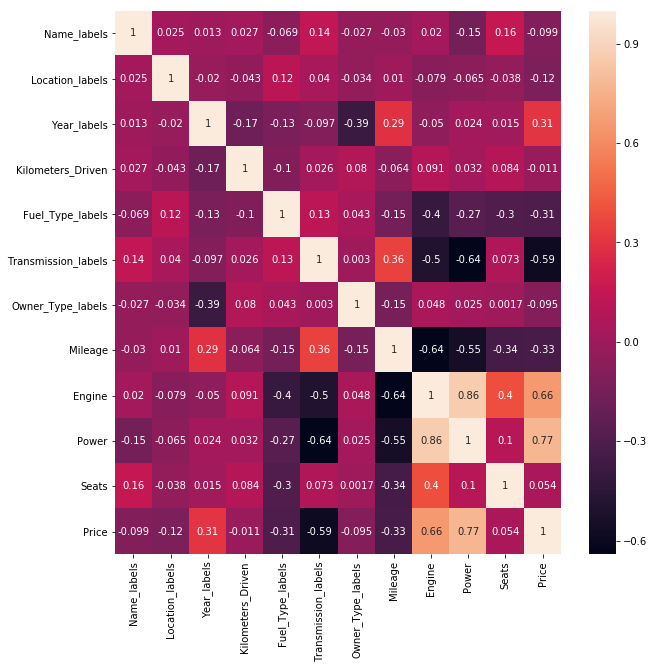

In [27]:
f,ax = plt.subplots(figsize = (10,10))
sns.heatmap(data_train.corr(),annot = True)
plt.show()

### Phase- III: Feature Selection using RFECV

In [28]:
train = data_train[['Name_labels','Location_labels','Year_labels','Kilometers_Driven','Fuel_Type_labels',
                   'Transmission_labels','Owner_Type_labels','Mileage','Engine','Power','Seats','Price']]
train.head()

,Name_labels,Location_labels,Year_labels,Kilometers_Driven,Fuel_Type_labels,Transmission_labels,Owner_Type_labels,Mileage,Engine,Power,Seats,Price
0,1200,9,12,0.011051,0,1,0,0.744289,0.156261,0.045569,5.0,1.75
1,512,10,17,0.006281,1,1,0,0.488946,0.254809,0.174971,5.0,12.50
2,486,2,13,0.007051,4,1,0,0.434783,0.190179,0.103652,5.0,4.50
3,1059,2,14,0.013358,1,1,0,0.529477,0.198448,0.103766,7.0,6.00
4,23,3,15,0.006231,1,0,2,0.324245,0.319946,0.202739,5.0,17.74


In [29]:
X = train.iloc[:,:-1]
y = train['Price']
X = np.asarray(X)
y = np.asarray(y)

In [30]:
import xgboost
xgb = xgboost.XGBRegressor(n_estimators = 400, learning_rate = 0.1, gamma = 0.2, subsample = 1.0,
                           colsample_bytree = 0.8, max_depth = 5, eta = 0.5, seed = 0, reg_alpha = 10,
                           objective = 'reg:squarederror', scale_pos_weight = 1,
                           min_child_weight = 1, eval_metric = 'rmse')
model = xgb

In [31]:
from sklearn.feature_selection import RFECV
rfecv = RFECV(model, step=1, min_features_to_select=1, cv= 7, scoring='neg_mean_absolute_error')
rfecv.fit(X, y)

RFECV(cv=7,
   estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.5,
       eval_metric='rmse', gamma=0.2, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_es..._alpha=10, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=1.0, verbosity=1),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

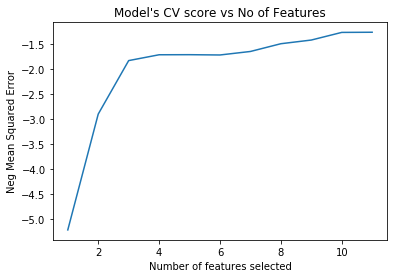

In [32]:
#PLot # of features selected vs. Model Score
plt.figure()
plt.title('Model\'s CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Neg Mean Squared Error")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Phase- IV: Model Deployment Phase

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_eval, y_train, y_eval = train_test_split(X,y, test_size = 0.2, shuffle = True, random_state = 50)

#### Using Linear Regression Model

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [36]:
reg.score(x_eval,y_eval)

0.7201288505912424

#### Using Gradient Boosting Model

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

In [38]:
reg = GradientBoostingRegressor(n_estimators = 400, max_depth = 5, learning_rate = 0.1, loss = 'ls',
                               min_samples_split = 2)
reg.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
reg.score(x_eval,y_eval)

0.9321374300547711

#### Using XGBoost model

In [40]:
import xgboost

In [41]:
# Training and evaluation
xgb = xgboost.XGBRegressor(n_estimators = 400, learning_rate = 0.1, gamma = 0.2, subsample = 1.0,
                           colsample_bytree = 0.8, max_depth = 4, eta = 0.5, seed = 0,
                           reg_alpha = 7, reg_lambda = 5, objective = 'reg:squarederror', scale_pos_weight = 1,
                           min_child_weight = 1, eval_metric = 'rmse')

xgb.fit(x_train,y_train)
y_pred = xgb.predict(x_eval)
xgb.score(x_eval,y_eval)

0.9474248319434981

In [45]:
# Printing results for comparison
for i in range(len(x_eval)):
    print(str(y_pred[i]) + ' || ' + str(y_eval[i]))

5.617125 || 5.38
12.22583 || 12.9
3.1037323 || 3.25
9.583236 || 10.82
4.1534576 || 4.35
3.9956472 || 3.35
38.732285 || 38.15
4.6655984 || 5.6
3.7732425 || 2.8
6.5030527 || 6.79
1.319959 || 1.5
4.6871533 || 3.65
7.462818 || 7.1
1.4311526 || 1.3
6.300872 || 6.2
3.7164264 || 4.0
4.5388784 || 3.5
4.481742 || 4.0
1.8490282 || 1.0
2.0408568 || 2.3
10.607916 || 12.95
5.969771 || 5.25
4.4636745 || 4.3
8.801855 || 8.73
7.3315415 || 7.1
0.92483175 || 1.2
1.1379038 || 1.6
4.903061 || 4.75
5.497356 || 5.7
4.8510814 || 4.75
8.294973 || 11.25
3.7094524 || 3.55
7.2660136 || 8.0
2.5982182 || 3.5
4.582476 || 4.95
2.651347 || 3.5
5.835973 || 4.8
8.130882 || 11.56
9.835833 || 11.31
7.3682065 || 8.5
6.5796623 || 7.25
40.83746 || 36.0
1.9633553 || 2.3
1.654393 || 2.0
6.2400007 || 5.75
1.5063938 || 1.65
11.858242 || 11.0
1.3988805 || 1.35
2.2207532 || 2.85
56.443752 || 56.8
12.462733 || 12.25
4.3640556 || 3.7
18.656712 || 16.8
18.025024 || 17.75
7.1094317 || 5.27
12.74763 || 12.5
35.79043 || 32.0
29.927898 

9.769886 || 9.47
2.984512 || 3.1
6.2095757 || 5.8
4.4806843 || 4.25
38.22447 || 39.05
23.361013 || 22.0
2.2479253 || 1.75
2.5806057 || 2.49
6.104285 || 5.4
8.169226 || 9.46
1.0370896 || 1.25
0.749573 || 0.85
3.1220496 || 3.15
3.7701082 || 2.85
2.4042792 || 2.75
3.0595043 || 3.1
3.499858 || 3.6
3.3638995 || 3.01
3.7886794 || 3.5
3.1557 || 3.71
2.675214 || 3.07
2.4601674 || 2.45
10.921417 || 10.65
2.4037013 || 2.85
4.635425 || 5.35
6.973394 || 6.15
23.709387 || 24.0
1.4427631 || 3.2
8.858762 || 6.58
6.8641796 || 7.75
5.687772 || 6.1
3.3257947 || 3.25
6.965256 || 6.5
4.7390223 || 5.53
6.86646 || 6.35
6.8153486 || 7.26
11.653167 || 14.14
14.330952 || 17.74
5.045271 || 5.11
6.5029154 || 5.55
4.468754 || 4.79
2.6807764 || 2.65
5.074498 || 4.74
5.5763416 || 6.75
1.8731443 || 1.28
1.7368344 || 1.5
7.1784096 || 7.45
9.640582 || 11.77
2.1485314 || 2.25
7.8145895 || 6.0
5.355024 || 5.0
3.326714 || 2.35
4.191413 || 5.32
2.7309287 || 2.75
2.8343472 || 2.75
1.5848082 || 2.15
8.4416275 || 8.58
4.1214

#### Wrapping the work into a function and storing results in a csv file

In [46]:
# Function for test value prediction
def predict_price_for_used_cars(data, model):
    data['Power'] = pd.to_numeric(data['Power'],errors = 'coerce')
    # Replacing 0's with appropriate values
    data['Mileage'] = data['Mileage'].replace(0,data_train['Mileage'].mean())
    data['Seats'] = data['Seats'].replace(0,data['Seats'].mode()[0])
    # Normalizing the numerical columns to bring them onto same scale
    data['Mileage']=(data['Mileage']-data['Mileage'].min())/(data['Mileage'].max()-data['Mileage'].min())
    data['Engine']=(data['Engine']-data['Engine'].min())/(data['Engine'].max()-data['Engine'].min())
    data['Power']=(data['Power']-data['Power'].min())/(data['Power'].max()-data['Power'].min())
    data['Kilometers_Driven']=(data['Kilometers_Driven']-data['Kilometers_Driven'].min())/(data['Kilometers_Driven'].max()-data['Engine'].min())
    # Dropping max NaNs column
    data  = data.drop(labels = 'New_Price',axis = 1)
    data['Power'].fillna(data['Power'].median(), inplace = True)
    data['Engine'].fillna(data['Engine'].median(), inplace = True)
    data['Mileage'].fillna(data['Mileage'].median(), inplace = True)
    data['Seats'].fillna(data['Seats'].mode()[0], inplace = True)
    # Numerical coding of the categorical columns
    label_codex = LabelEncoder()
    data["Name_labels"] = label_codex.fit_transform(data["Name"])
    data["Year_labels"] = label_codex.fit_transform(data["Year"])
    data["Owner_Type_labels"] = label_codex.fit_transform(data["Owner_Type"])
    data["Location_labels"] = label_codex.fit_transform(data["Location"])
    data["Fuel_Type_labels"] = label_codex.fit_transform(data["Fuel_Type"])
    data["Transmission_labels"] = label_codex.fit_transform(data["Transmission"])
    # Rearraning the columns
    data = data[['Name_labels', 'Location_labels', 'Year_labels', 'Kilometers_Driven', 'Fuel_Type_labels',
       'Transmission_labels', 'Owner_Type_labels', 'Mileage', 'Engine', 'Power', 'Seats']]
    # Data to array
    X = np.asarray(data)
    # Model prediction
    result = model.predict(X)
    return result

In [47]:
data_test = pd.read_csv("Data_Test.csv")

In [48]:
data_test.dtypes

Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage              float64
Engine               float64
Power                 object
Seats                float64
New_Price             object
dtype: object

In [49]:
price_predicted = predict_price_for_used_cars(data_test, xgb)

In [50]:
for i in range(len(price_predicted)):
    price_predicted[i] = round(price_predicted[i],2)

In [51]:
df = pd.DataFrame({'Price':price_predicted})
df.to_excel('submission.xlsx', index = False)